# Library

### To improve
 - Maybe some pre-processing?
 - See if pattern 

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import pickle as pkl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression


## Exploration of the dataset

In [145]:
# loading dataset and have information about it
data = pd.read_csv("/Users/sylvainestebe/Code/DataSci-AU-24-1/data/bikes.csv")
data.info()
# data.describe() if needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


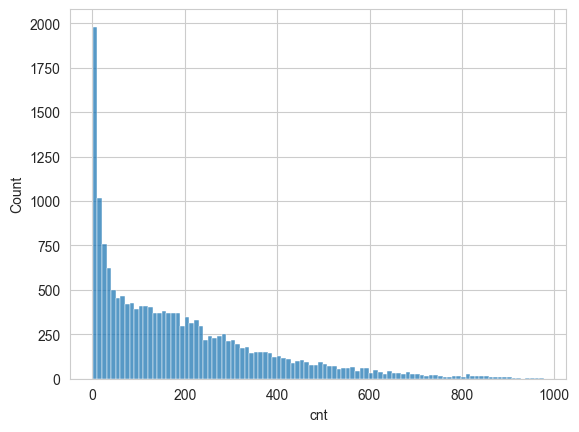

In [146]:
# Distribution of the outcome variable
sns.histplot(data=data, x='cnt', binwidth=10)
plt.show()

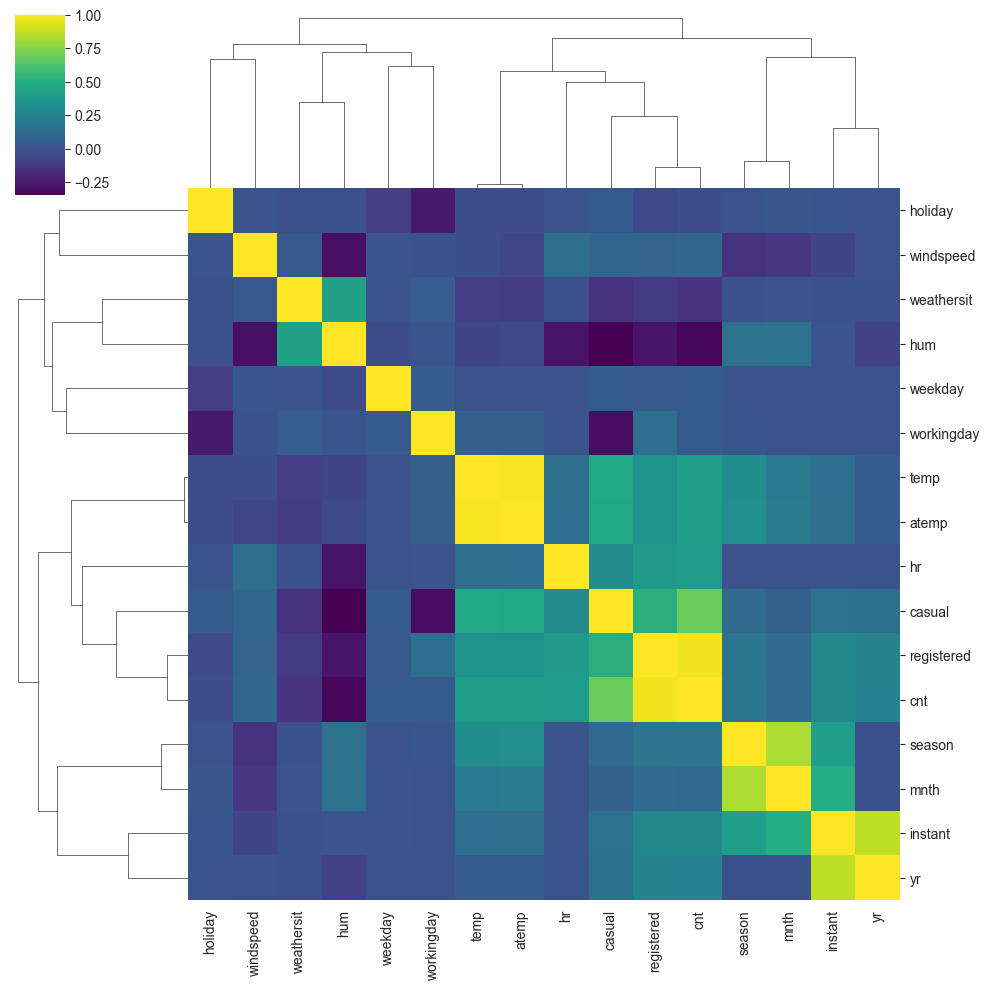

In [147]:
# Correlation structure of the dataset
# hum seems correlated with our target (cnt)
sns.clustermap(data.drop("dteday", axis=1).corr(), cmap='viridis')
plt.show()

<Axes: xlabel='casual', ylabel='cnt'>

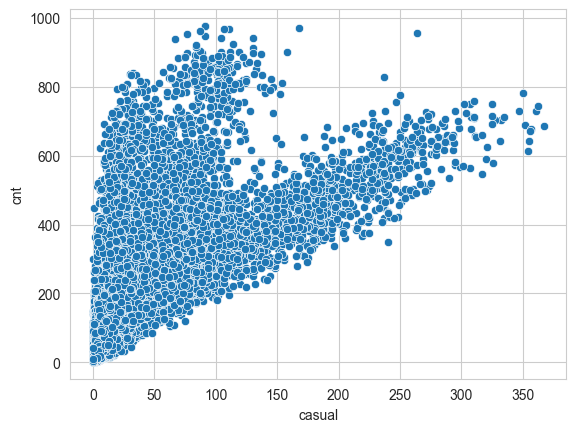

In [148]:
# casual seems correlated positively with cnt
sns.scatterplot(data=data, x="casual", y="cnt")

<Axes: xlabel='hum', ylabel='cnt'>

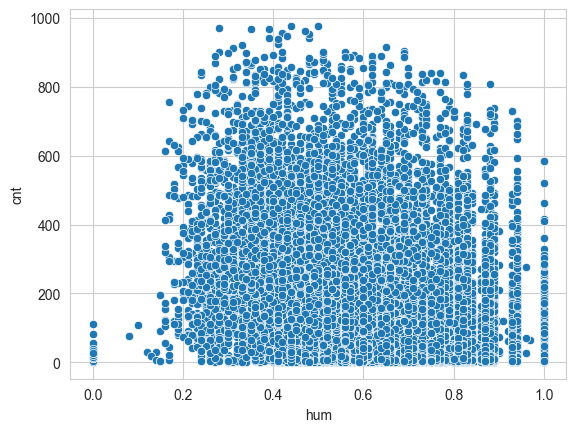

In [149]:
# humidity seems correlated negatively with cnt

sns.scatterplot(data=data, x="hum", y="cnt")


## Model

### Split train,test,validation

In [150]:
# removing categorical variable
X = data.drop("dteday", axis=1)
# target
y = data["cnt"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

In [151]:
# save the split
X =[X_train, X_val, X_test]
y = [y_train, y_val, y_test]
name = ['train', 'val', 'test']
for x,y,name in zip(X,y,name):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = data.columns
    df.to_csv(f'/Users/sylvainestebe/Code/DataSci-AU-24-1/data/{name}.csv')

### Model 0
Always predict the average of Y in the data

Example with small sample

In [152]:
performances = []

In [153]:
model_name = 'dummy'
name = ['train', 'val', 'test']
y_set = [y_train, y_val, y_test]

for y,nsplit in zip(y_set,name):
    performance = np.sqrt(mean_squared_error(y, 
                                             [y_train.mean()]*y.shape[0]))
    r2 = r2_score(y, [y_train.mean()]*y.shape[0])
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})


In [154]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 183.5925, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 174.2015, 'r2': -0.001},
 {'model': 'dummy', 'split': 'test', 'rmse': 178.0718, 'r2': -0.0012}]

### Model 1
Predict based on a linear model with 'instant' as the only predictor

In [155]:
linear_regressor = LinearRegression(fit_intercept = True)
reg = linear_regressor.fit(X_train["instant"].values.reshape(-1,1),y_train.reshape(-1,1))
pkl.dump(reg, file=open(f'/Users/sylvainestebe/Code/DataSci-AU-24-1/model/linear-instance.pkl', 'wb')) # save the model



In [156]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x["instant"].values.reshape(-1,1))
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-instance',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [157]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 183.5925, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 174.2015, 'r2': -0.001},
 {'model': 'dummy', 'split': 'test', 'rmse': 178.0718, 'r2': -0.0012},
 {'model': 'linear-instance',
  'split': 'train',
  'rmse': 175.8159,
  'r2': 0.0829},
 {'model': 'linear-instance', 'split': 'val', 'rmse': 167.9975, 'r2': 0.069},
 {'model': 'linear-instance', 'split': 'test', 'rmse': 172.9454, 'r2': 0.0556}]

### Model 2
Model including weather info (temperature, windspeed) and temporal parameters (e.g., `season`, `weekday`) as predictor

In [158]:
linear_regressor = LinearRegression(fit_intercept = True)
reg = linear_regressor.fit(X_train["hum"].values.reshape(-1,1),y_train.reshape(-1,1))
pkl.dump(reg, file=open(f'/Users/sylvainestebe/Code/DataSci-AU-24-1/model/linear-hum.pkl', 'wb')) # save the model



In [159]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x["hum"].values.reshape(-1,1))
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-hum',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [160]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 183.5925, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 174.2015, 'r2': -0.001},
 {'model': 'dummy', 'split': 'test', 'rmse': 178.0718, 'r2': -0.0012},
 {'model': 'linear-instance',
  'split': 'train',
  'rmse': 175.8159,
  'r2': 0.0829},
 {'model': 'linear-instance', 'split': 'val', 'rmse': 167.9975, 'r2': 0.069},
 {'model': 'linear-instance', 'split': 'test', 'rmse': 172.9454, 'r2': 0.0556},
 {'model': 'linear-hum', 'split': 'train', 'rmse': 174.0, 'r2': 0.1018},
 {'model': 'linear-hum', 'split': 'val', 'rmse': 164.0324, 'r2': 0.1125},
 {'model': 'linear-hum', 'split': 'test', 'rmse': 168.1846, 'r2': 0.1069}]

### Model 3

### SOME PROBLEMS HERE
A "kitchen sink" model, will all predictors included

In [161]:
X = data.iloc[:,3:16].values
y : data["cnt"].values


In [162]:
X_train.iloc[:,:16]

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
781,782,1,0,2,0,0,6,0,2,0.24,0.2424,0.70,0.1642,3,36,39
6347,6348,4,0,9,1,0,2,1,1,0.62,0.5455,0.94,0.1642,4,6,10
4675,4676,3,0,7,17,0,1,1,1,0.84,0.7879,0.49,0.3284,72,473,545
12011,12012,2,1,5,16,0,0,0,1,0.72,0.6515,0.42,0.3582,238,339,577
8793,8794,1,1,1,5,0,6,0,1,0.26,0.2727,0.75,0.1045,2,7,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16935,16936,4,1,12,10,0,4,1,1,0.32,0.3030,0.45,0.2836,28,139,167
9766,9767,1,1,2,21,0,4,1,2,0.34,0.3485,0.81,0.1045,3,142,145
4132,4133,3,0,6,2,0,0,0,1,0.62,0.6212,0.57,0.1045,17,70,87
17250,17251,1,1,12,15,0,3,1,3,0.26,0.2273,0.87,0.3582,0,13,13


In [163]:
linear_regressor = LinearRegression(fit_intercept = True)
reg = linear_regressor.fit(X_train.iloc[:,:16],y_train.reshape(-1,1))
pkl.dump(reg, file=open(f'/Users/sylvainestebe/Code/DataSci-AU-24-1/model/linear-ALL.pkl', 'wb')) # save the model



In [164]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-ALL',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [165]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 183.5925, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 174.2015, 'r2': -0.001},
 {'model': 'dummy', 'split': 'test', 'rmse': 178.0718, 'r2': -0.0012},
 {'model': 'linear-instance',
  'split': 'train',
  'rmse': 175.8159,
  'r2': 0.0829},
 {'model': 'linear-instance', 'split': 'val', 'rmse': 167.9975, 'r2': 0.069},
 {'model': 'linear-instance', 'split': 'test', 'rmse': 172.9454, 'r2': 0.0556},
 {'model': 'linear-hum', 'split': 'train', 'rmse': 174.0, 'r2': 0.1018},
 {'model': 'linear-hum', 'split': 'val', 'rmse': 164.0324, 'r2': 0.1125},
 {'model': 'linear-hum', 'split': 'test', 'rmse': 168.1846, 'r2': 0.1069},
 {'model': 'linear-ALL', 'split': 'train', 'rmse': 0.0, 'r2': 1.0},
 {'model': 'linear-ALL', 'split': 'val', 'rmse': 0.0, 'r2': 1.0},
 {'model': 'linear-ALL', 'split': 'test', 'rmse': 0.0, 'r2': 1.0}]

# Plot the performance


In [166]:
perf_df = pd.DataFrame(performances)

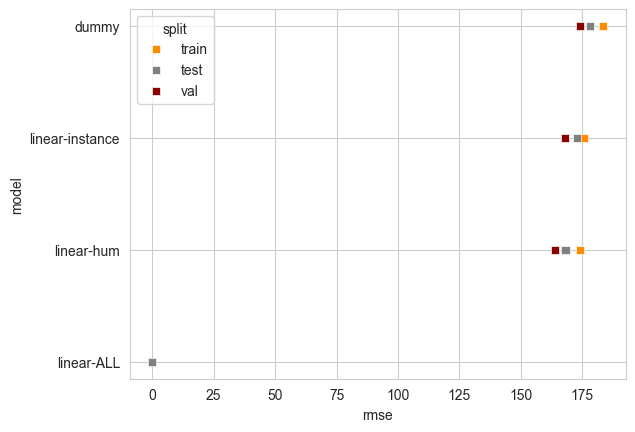

In [167]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

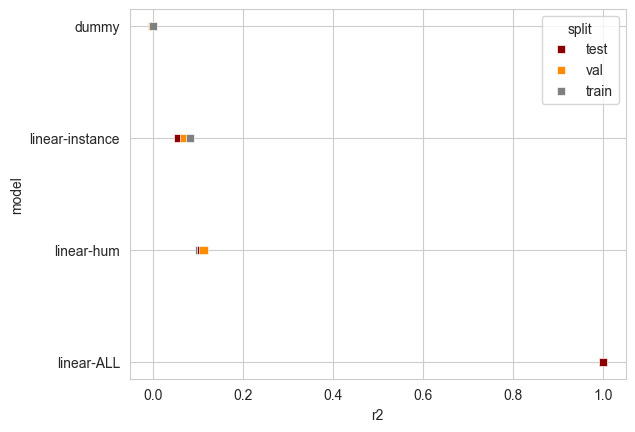

In [168]:
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=True), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkred', 'darkorange', 'grey'])
plt.show()